In [1]:
# Imports
import numpy as np
import numpy.ma as ma
import os
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import h5py as h5
from PyXRIM.Corrections import Corrector
from PyXRIM.misc import  bin_ndarray
from functions import *
from decompFunctions import *
import math
%matplotlib notebook

In [2]:
#Inputs
fname = 'D:\Libraries\Documents\Materials Informatics\LiCoO2_Al2O3_20160330.hdf5'
datasets = ['S026','S027','S028'] # name of raw dataset
procRefName = 'bkg_corrected' # reference name to append to rawData

In [3]:
# open h5file
f = h5.File(fname, mode='r') 
# Always open in read mode 'r'.
# Until you're ready to write into the file. This is especially true if your OS is not Unix-based like Windows.
rawg = f['20160330/Raw']
procg = f['20160330/Process']
meta = f['20160330/Meta']

In [4]:
#roi1x=slice(250,640)
#roi1y=slice(510,900)  #original 1024

roi1x=slice(0,1024)
roi1y=slice(0,1024)  #original 1024


i = 0;
for name in datasets:
    rawDset = rawg[name]
    procDset = f[rawDset.attrs['bkg_corrected']]   

    if i == 0:
        #data = procDset[:,:,:]
        data = procDset[:,roi1x,roi1y]
        datalog = procDset[:,roi1x,roi1y]+10
    
        twotheta = rawDset.attrs['delta']
        
        i = 1
    else:
        #data = np.vstack([data, procDset[:,:,:]])
        data = np.vstack([data, procDset[:,roi1x,roi1y]])
        datalog = np.vstack([datalog, procDset[:,roi1x,roi1y]+10])

        twotheta = np.hstack([twotheta,rawDset.attrs['delta']])
        

In [5]:
##Insert DELETE CODE
delete = [0]

data_new = np.vstack([data[1:25,:,:],data[42:88,:,:]])
datalog_new = np.vstack([datalog[1:25,:,:],datalog[42:88,:,:]])
twotheta_new = np.hstack([twotheta[1:25],twotheta[42:88]])

print data_new.shape
print datalog_new.shape
print twotheta_new.shape

(70L, 1024L, 1024L)
(70L, 1024L, 1024L)
(70L,)


<IPython.core.display.Javascript object>


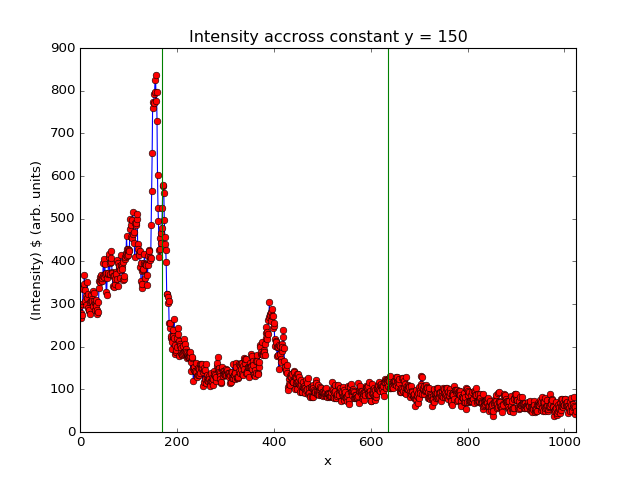

In [6]:
fig,ax = plt.subplots()
ax.set_title('Intensity accross constant y = 150')
ax.plot(data_new[30,:,150],marker = 'o', markerfacecolor='r')
ax.set_xlabel('x')
ax.set_ylabel('(Intensity) $ (arb. units)')
ax.set_xlim([0,1024])
ax.set_ylim([0,900])
ax.plot((170,170),(0,900),color = 'g')
ax.plot((635,635),(0,900),color = 'g')

<IPython.core.display.Javascript object>


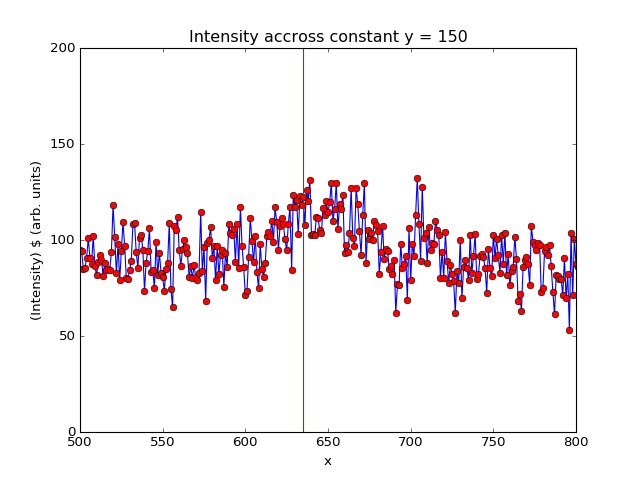

In [7]:
fig,ax = plt.subplots()
ax.set_title('Intensity accross constant y = 150')
ax.plot(data_new[30,:,150],marker = 'o', markerfacecolor='r')
ax.set_xlabel('x')
ax.set_ylabel('(Intensity) $ (arb. units)')
ax.set_xlim([500,800])
ax.set_ylim([0,200])
ax.plot((170,170),(0,900),color = 'g')
ax.plot((635,635),(0,900),color = 'g')

<IPython.core.display.Javascript object>


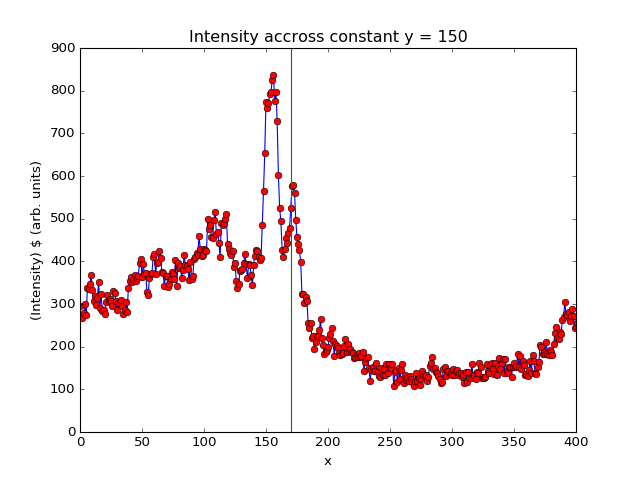

In [8]:
fig,ax = plt.subplots()
ax.set_title('Intensity accross constant y = 150')
ax.plot(data_new[30,:,150],marker = 'o', markerfacecolor='r')
ax.set_xlabel('x')
ax.set_ylabel('(Intensity) $ (arb. units)')
ax.set_xlim([0,400])
ax.set_ylim([0,900])
ax.plot((170,170),(0,900),color = 'g')
ax.plot((635,635),(0,900),color = 'g')

In [9]:
#Mask Data
mask = np.zeros(data_new.shape)
for x in range(0,1024):
    for y in range(0,1024):
        l1L = -0.0004*x*x - 0.2052*x+445.45
        l2L = 0.0017*x*x + 0.1998*x + 584
        
        l1U = -0.0018*x*x - 0.038*x + 221
        l2U = 0.0006*x*x+0.27*x+328.58
        
        if ((y > l1U ) and (y < l1L)) or ((y > l2U) and (y < l2L)):
            mask[:,y,x] = 1
datamasked = ma.masked_array(data_new,mask)

<IPython.core.display.Javascript object>


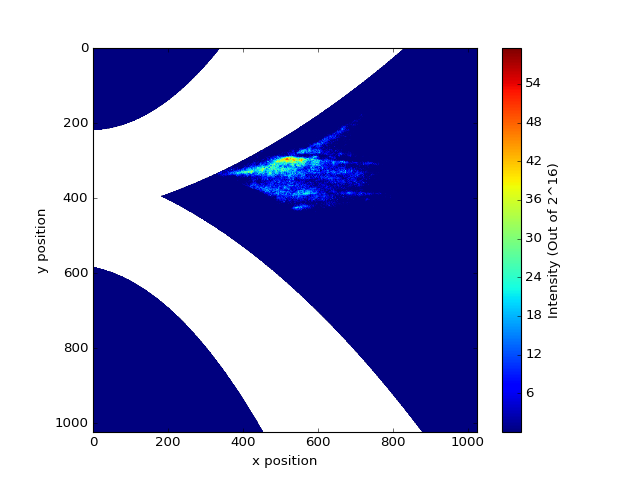

In [10]:
fig,ax = plt.subplots()
cax = ax.imshow(datamasked[10,:,:])
cbar = fig.colorbar(cax)
cbar.set_label('Intensity (Out of 2^16)')
ax.set_xlabel('x position')
ax.set_ylabel('y position')

<IPython.core.display.Javascript object>


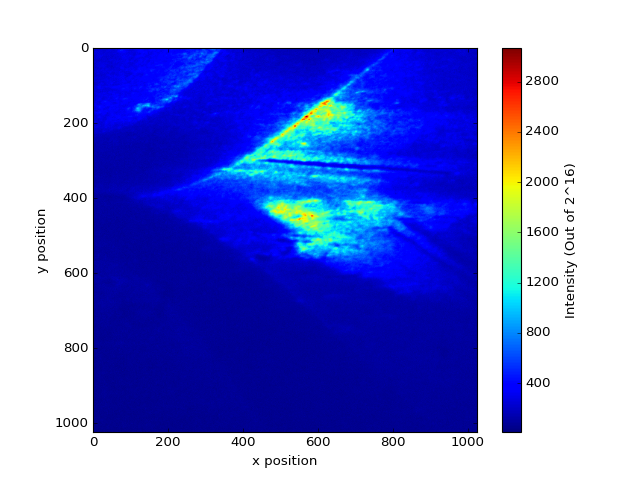

In [11]:
fig,ax = plt.subplots()
cax = ax.imshow(data_new[30,:,:])
cbar = fig.colorbar(cax)
cbar.set_label('Intensity (Out of 2^16)')
ax.set_xlabel('x position')
ax.set_ylabel('y position')

In [12]:
# PCA
xvals= twotheta_new
# You should do one PCA with logscaling = True and another with logscaling = False to compare.

mask_prep = preping(mask, logscaling = False, feature_scaling=False, feature_range=(0.1,1))
data_prep = preping(data_new, logscaling = False, feature_scaling=False, feature_range=(0.1,1))
datalog_prep = preping(datalog_new, logscaling = True, feature_scaling=False, feature_range=(0.1,1))


<IPython.core.display.Javascript object>


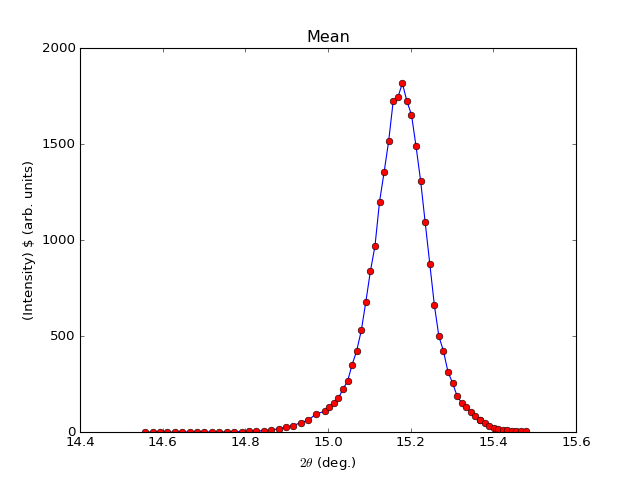

<IPython.core.display.Javascript object>


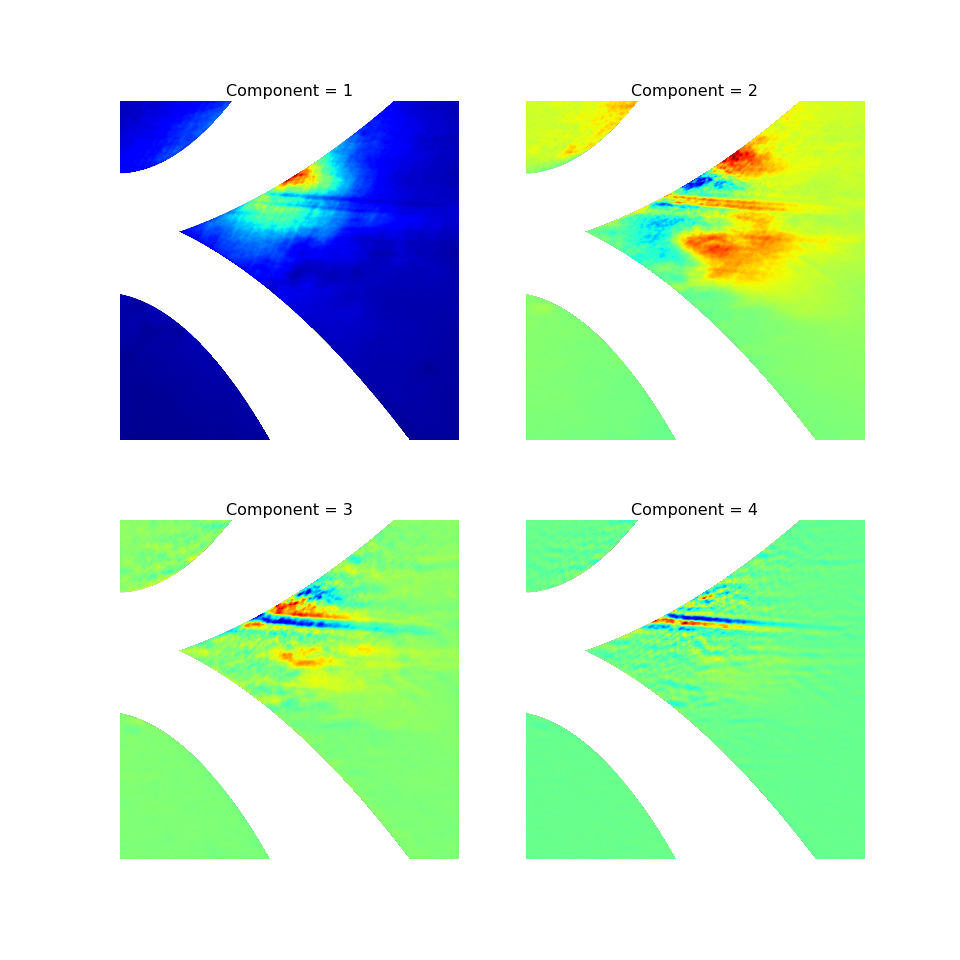

<IPython.core.display.Javascript object>


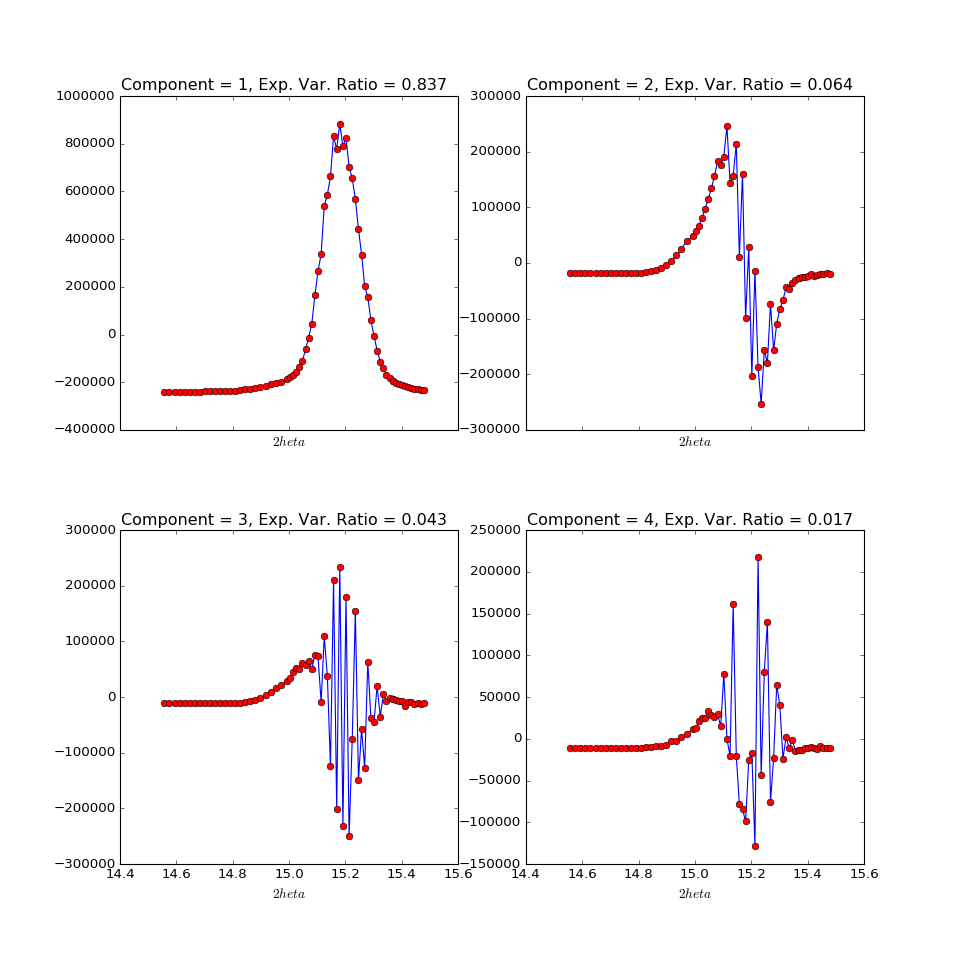

In [13]:
# set the number of principal components we want PCA to use. Try multiple numbers.
n_comp = 4
r_comp = 8
#projec, eigenvec, var_ratio, pca = doPCA(data2, n_comp, xvals=xvals,xlabel='$2\theta$',cmap='rainbow')
projec, eigenvec, var_ratio, pca = doPCA_Mask(data_prep, n_comp, mask, xvals=xvals,xlabel='$2\theta$',
                                         cmap='rainbow',normalize = True, returnComponents = r_comp)


<IPython.core.display.Javascript object>


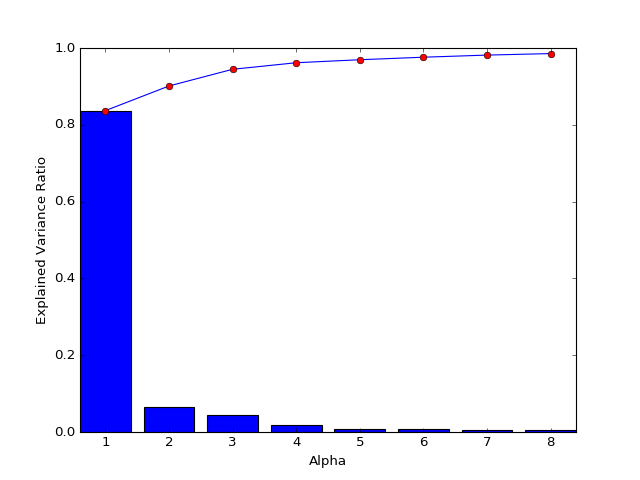

(0, 1)

In [14]:
v = var_ratio[0]
vSum = var_ratio[0]
for i in range(1,var_ratio.shape[0]):
    v = np.hstack([v,var_ratio[i]])
    vSum = np.hstack([vSum,np.sum(var_ratio[0:i+1])])
    
fig,ax = plt.subplots()
ax.bar(np.arange(1,var_ratio.shape[0]+1)-0.4,v)
ax.plot(np.arange(1,var_ratio.shape[0]+1),vSum,marker = 'o', markerfacecolor='r')
ax.set_xlabel('Alpha')
ax.set_xlim([0.6,var_ratio.shape[0]+0.4])
ax.set_ylabel('Explained Variance Ratio')
ax.set_ylim([0,1])

<IPython.core.display.Javascript object>


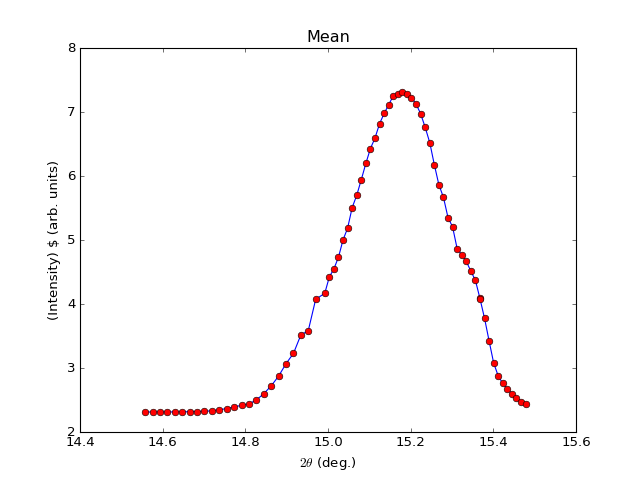

<IPython.core.display.Javascript object>


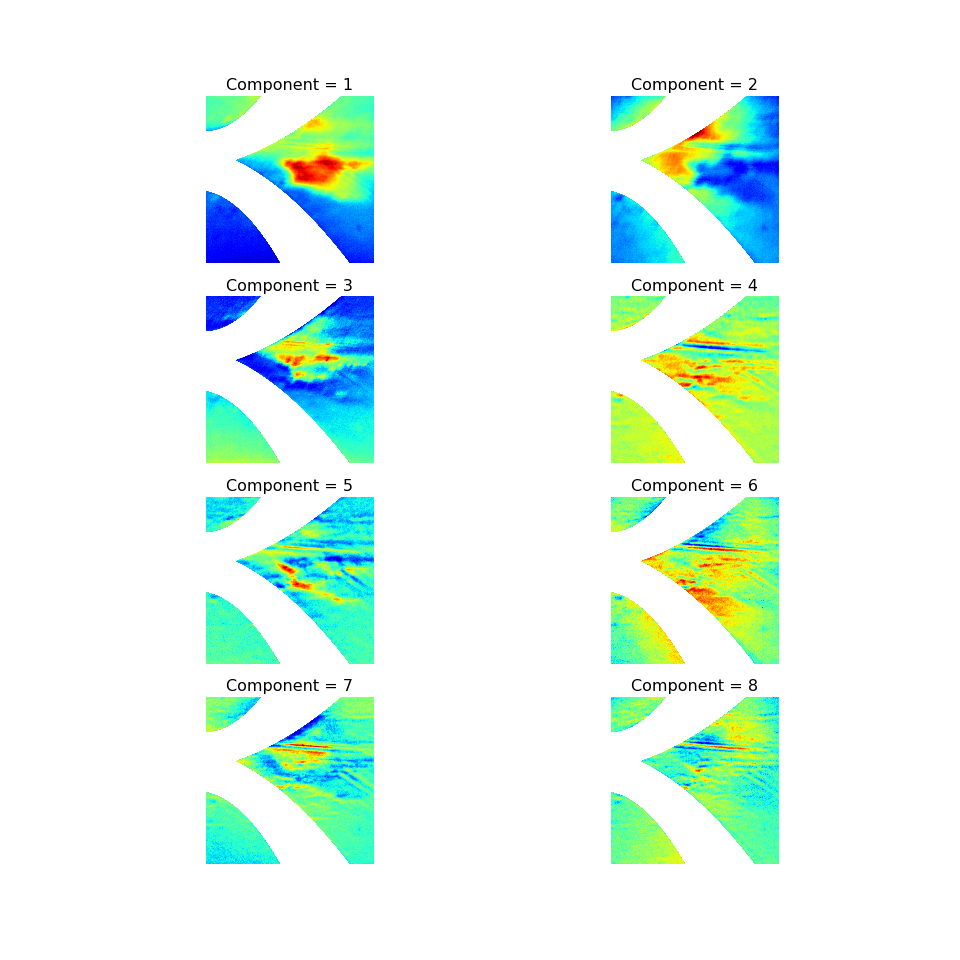

<IPython.core.display.Javascript object>


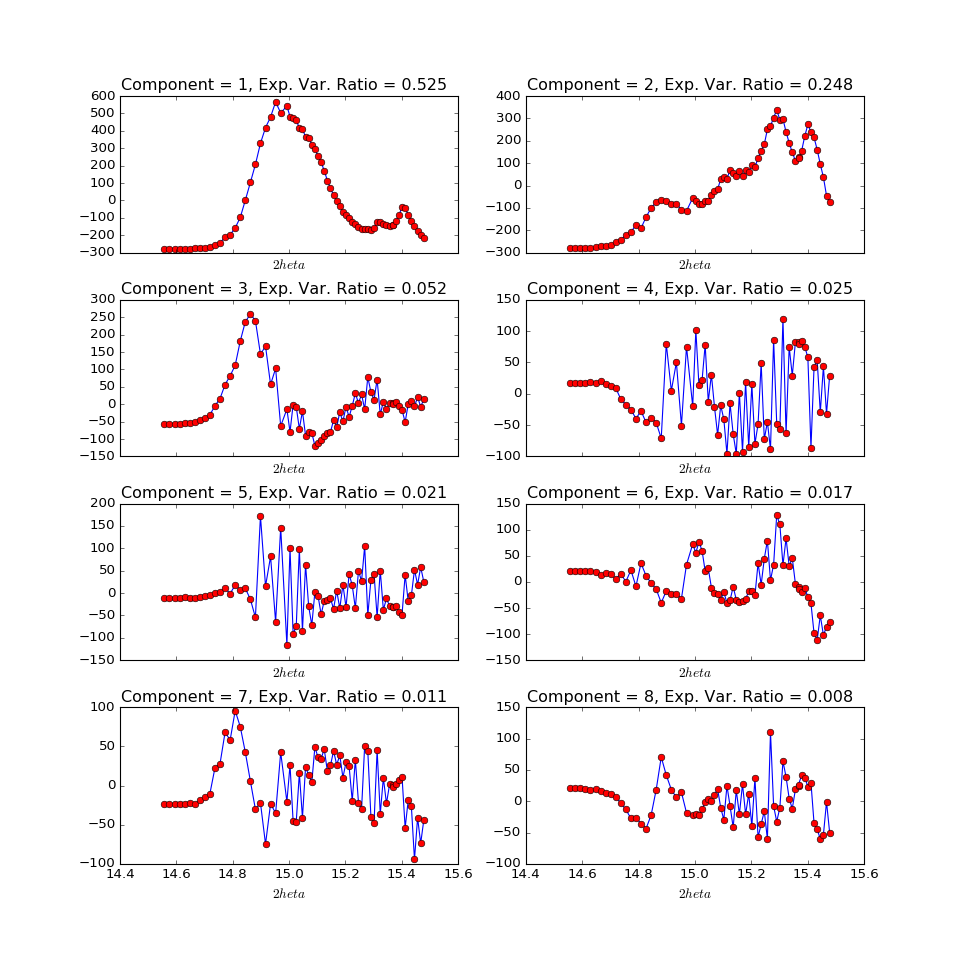

In [15]:
# set the number of principal components we want PCA to use. Try multiple numbers.
n_comp = 8
r_comp = 20
#projec, eigenvec, var_ratio, pca = doPCA(data2, n_comp, xvals=xvals,xlabel='$2\theta$',cmap='rainbow')
projec, eigenvec, var_ratio, pca = doPCA_Mask(datalog_prep, n_comp, mask, xvals=xvals,xlabel='$2\theta$',
                                         cmap='rainbow',normalize = True, returnComponents = r_comp)

In [ ]:
v = var_ratio[0]
vSum = var_ratio[0]
for i in range(1,var_ratio.shape[0]):
    v = np.hstack([v,var_ratio[i]])
    vSum = np.hstack([vSum,np.sum(var_ratio[0:i+1])])
    
fig,ax = plt.subplots()
ax.bar(np.arange(1,var_ratio.shape[0]+1)-0.4,v)
ax.plot(np.arange(1,var_ratio.shape[0]+1),vSum,marker = 'o', markerfacecolor='r')
ax.set_xlabel('Alpha')
ax.set_xlim([0.6,var_ratio.shape[0]+0.4])
ax.set_ylabel('Explained Variance Ratio')
ax.set_ylim([0,1])

<IPython.core.display.Javascript object>


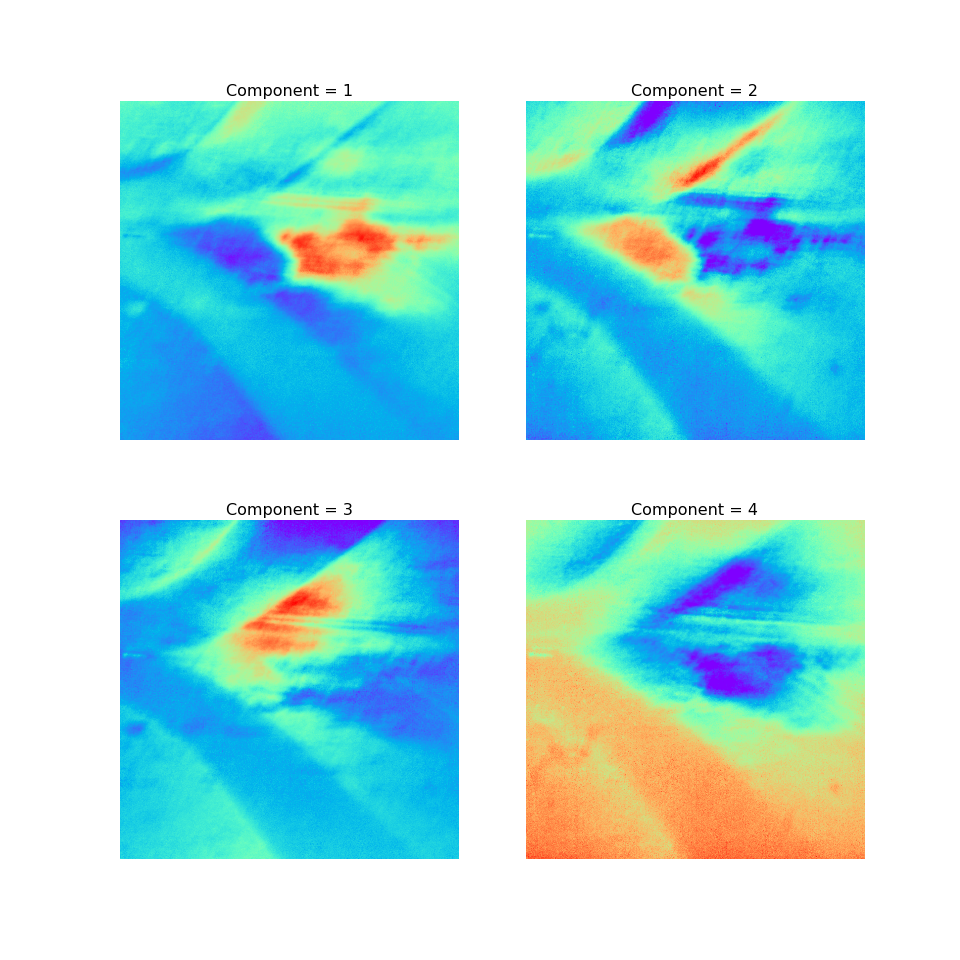

<IPython.core.display.Javascript object>


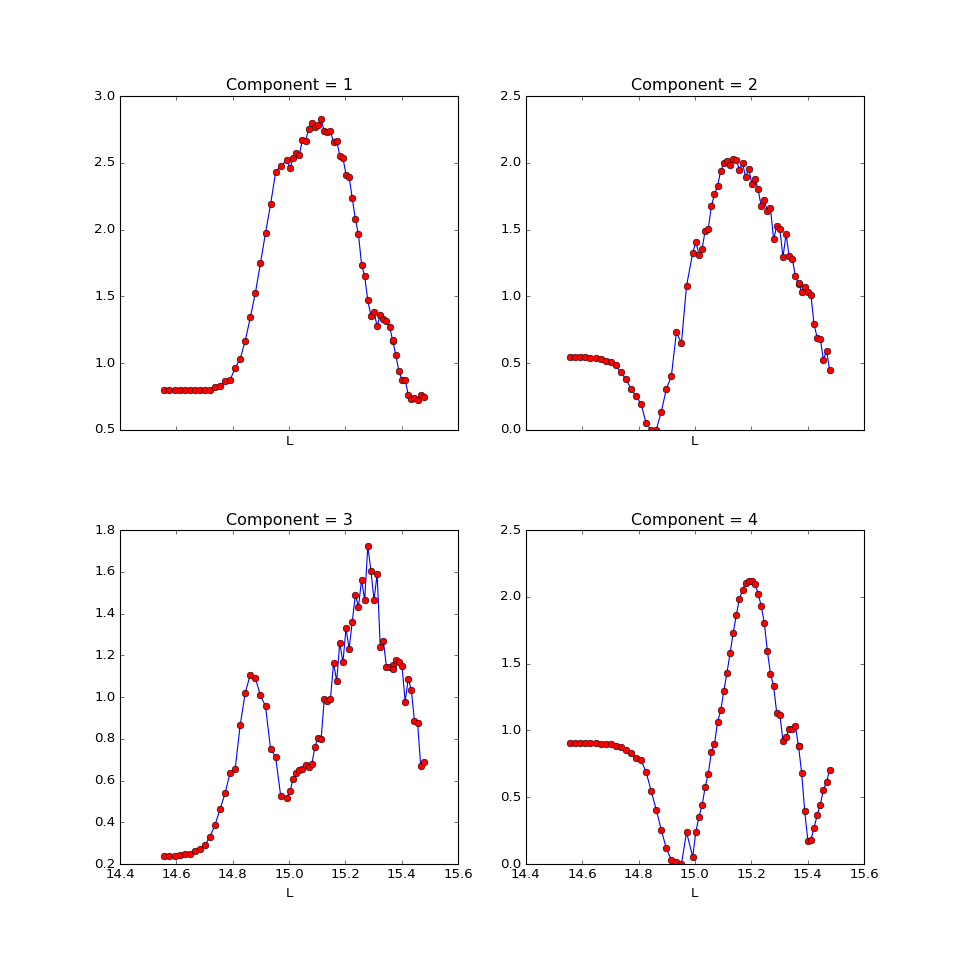

In [17]:
n_comp = 4
projec, eigenvec, nmf = doNMF(datalog_prep, 4, xvals=xvals,xlabel='L',cmap='rainbow')

<IPython.core.display.Javascript object>


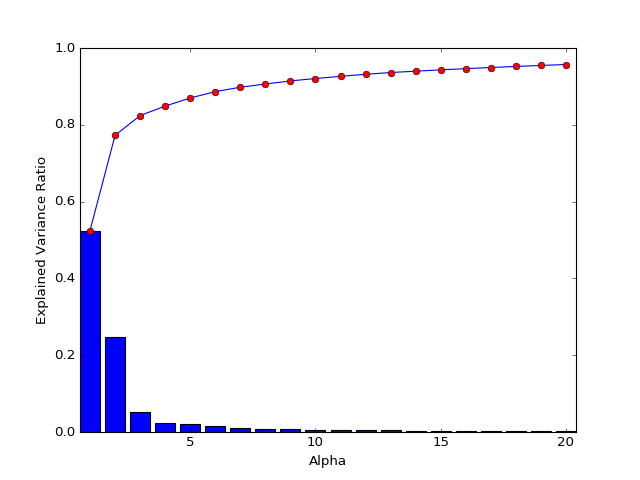

(0, 1)